# Train Likelihood Ratio Estimator 

In [13]:
from __future__ import absolute_import, division, print_function, unicode_literals

import logging
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

from madminer.core import MadMiner
from madminer.sampling import SampleAugmenter
from madminer import sampling
from madminer.ml import ParameterizedRatioEstimator

# MadMiner output
logging.basicConfig(
    format='%(asctime)-5.5s %(name)-20.20s %(levelname)-7.7s %(message)s',
    datefmt='%H:%M',
    level=logging.INFO
)

# Output of all other modules (e.g. matplotlib)
for key in logging.Logger.manager.loggerDict:
    if "madminer" not in key:
        logging.getLogger(key).setLevel(logging.WARNING)

## Prepare Training and Testing Datasets

In [40]:
sampler = SampleAugmenter('meta/delphes_data_shuffled.h5')
miner = MadMiner()
miner.load('meta/setup.h5')

#Train Sample
x, theta0, theta1, y, r_xz, t_xz, n_effective = sampler.sample_train_ratio(
    theta0=sampling.benchmarks(miner.benchmarks.keys()),
    theta1=sampling.benchmark('benchmark_0'),
    n_samples=200000,
    folder='./meta/samples',
    filename='train_ratio',
)

# Test Sample
_ = sampler.sample_test(
    theta=sampling.benchmark('benchmark_25'),
    n_samples=10000,
    folder='./meta/samples',
    filename='test'
)

# Calibration Sample
_ = sampler.sample_test(
    theta=sampling.benchmark('benchmark_0'),
    n_samples=20000,
    folder='./meta/samples',
    filename='calibrate'
)


01:10 madminer.analysis    INFO    Loading data from meta/delphes_data_shuffled.h5
01:10 madminer.analysis    INFO    Found 2 parameters
01:10 madminer.analysis    INFO    Did not find nuisance parameters
01:10 madminer.analysis    INFO    Found 121 benchmarks, of which 121 physical
01:10 madminer.analysis    INFO    Found 8 observables
01:10 madminer.analysis    INFO    Found 879147 events
01:10 madminer.analysis    INFO    Did not find morphing setup.
01:10 madminer.analysis    INFO    Did not find nuisance morphing setup
01:10 madminer.core        INFO    Found 2 parameters:
01:10 madminer.core        INFO       mzp (LHA: mass 56, maximal power in squared ME: (0,), range: (275.0, 325.0))
01:10 madminer.core        INFO       gzp (LHA: dminputs 2, maximal power in squared ME: (0,), range: (0.0, 5.0))
01:10 madminer.core        INFO    Found 121 benchmarks:
01:10 madminer.core        INFO       benchmark_0: mzp = 2.75e+02, gzp = 0.00e+00
01:10 madminer.core        INFO       benchmark

01:10 madminer.core        INFO       benchmark_93: mzp = 3.15e+02, gzp = 2.50
01:10 madminer.core        INFO       benchmark_94: mzp = 3.15e+02, gzp = 3.00
01:10 madminer.core        INFO       benchmark_95: mzp = 3.15e+02, gzp = 3.50
01:10 madminer.core        INFO       benchmark_96: mzp = 3.15e+02, gzp = 4.00
01:10 madminer.core        INFO       benchmark_97: mzp = 3.15e+02, gzp = 4.50
01:10 madminer.core        INFO       benchmark_98: mzp = 3.15e+02, gzp = 5.00
01:10 madminer.core        INFO       benchmark_99: mzp = 3.20e+02, gzp = 0.00e+00
01:10 madminer.core        INFO       benchmark_100: mzp = 3.20e+02, gzp = 0.50
01:10 madminer.core        INFO       benchmark_101: mzp = 3.20e+02, gzp = 1.00
01:10 madminer.core        INFO       benchmark_102: mzp = 3.20e+02, gzp = 1.50
01:10 madminer.core        INFO       benchmark_103: mzp = 3.20e+02, gzp = 2.00
01:10 madminer.core        INFO       benchmark_104: mzp = 3.20e+02, gzp = 2.50
01:10 madminer.core        INFO       bench

## Train Estimator

In [14]:
estimator = ParameterizedRatioEstimator(
    n_hidden=(60,60,60),
    activation="tanh"
)

estimator.train(
    method='rolr',
    theta='meta/samples/theta0_train_ratio.npy',
    x='meta/samples/x_train_ratio.npy',
    y='meta/samples/y_train_ratio.npy',
    r_xz='meta/samples/r_xz_train_ratio.npy',
    optimizer="adam",
    initial_lr=0.002,
    batch_size=2000,
    n_epochs=100,
)

estimator.save('models/rolr')

23:18 madminer.ml          INFO    Starting training
23:18 madminer.ml          INFO      Method:                 rolr
23:18 madminer.ml          INFO      Batch size:             200
23:18 madminer.ml          INFO      Optimizer:              amsgrad
23:18 madminer.ml          INFO      Epochs:                 100
23:18 madminer.ml          INFO      Learning rate:          0.001 initially, decaying to 0.0001
23:18 madminer.ml          INFO      Validation split:       0.25
23:18 madminer.ml          INFO      Early stopping:         True
23:18 madminer.ml          INFO      Scale inputs:           True
23:18 madminer.ml          INFO      Shuffle labels          False
23:18 madminer.ml          INFO      Samples:                all
23:18 madminer.ml          INFO    Loading training data
23:18 madminer.utils.vario WARNING Warning: file meta/samples/r_xz_train_ratio.npy contains 0 NaNs and 75454 Infs, compared to 124438 finite numbers!
23:18 madminer.utils.vario WARNING Warning: file

## Evaluate Likelihood Ratio Estimator

Define grid that neural network will be evaluated on (does NOT need to be made of only benchmark points - the NN can interpolate in theta space now).

In [41]:
grid_res = 51

theta_m = np.linspace(275.,325.,grid_res)
theta_g = np.linspace(0.,5.,grid_res)
theta0, theta1 = np.meshgrid(theta_m, theta_g)
theta_grid = np.vstack((theta0.flatten(), theta1.flatten())).T
np.save('meta/samples/theta_grid.npy', theta_grid)

theta_denom = np.array([[300.,0.]])
np.save('meta/samples/theta_ref.npy', theta_denom)

In [42]:
estimator.load('models/rolr')

log_r_hat, _ = estimator.evaluate_log_likelihood_ratio(
    theta='meta/samples/theta_grid.npy',
    x='meta/samples/x_test.npy',
    evaluate_score=False
)

In [53]:
# Calibration
log_r_hat_calibrate, _ = estimator.evaluate_log_likelihood_ratio(
    theta='meta/samples/theta_grid.npy',
    x='meta/samples/x_calibrate.npy',
    evaluate_score=False
)

calibration_diff = np.log(np.mean(np.exp(log_r_hat_calibrate), axis=1))
calibrated_llr = (log_r_hat.T - calibration_diff).T

## Test a point that isnt the SM!

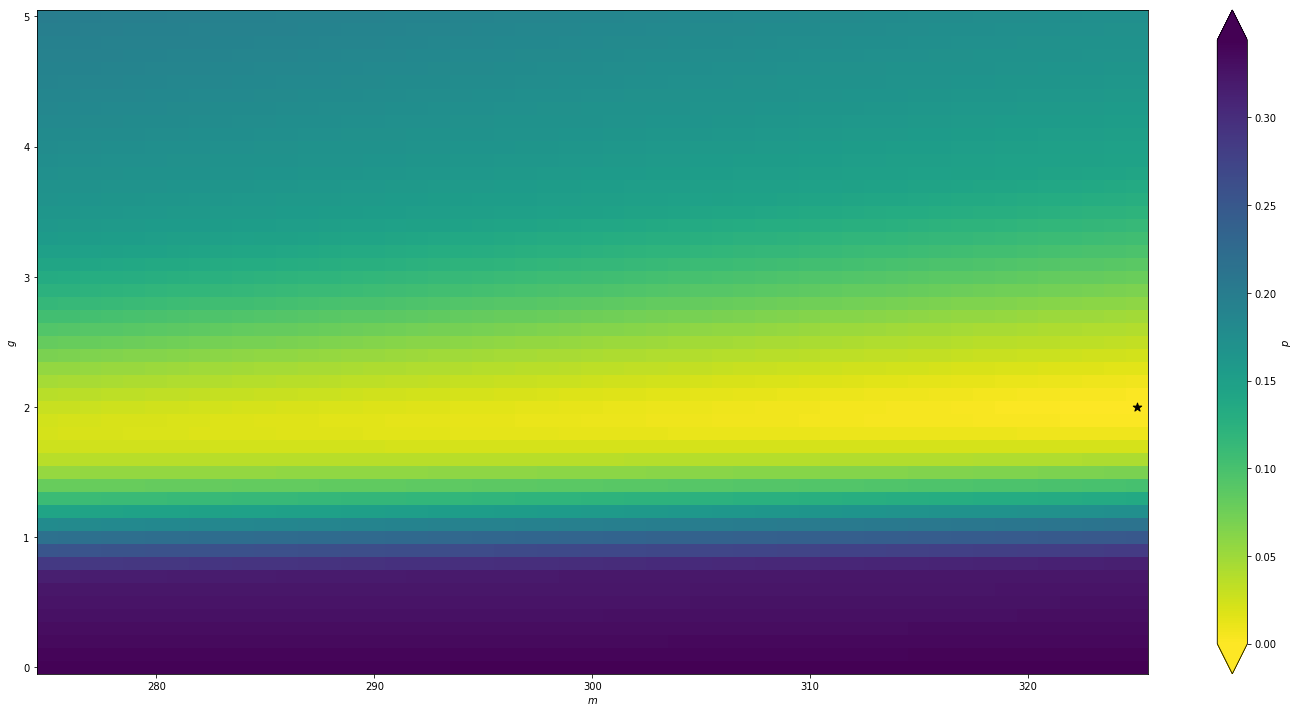

In [65]:
bin_size_m = theta_m[1] - theta_m[0]
edges_m = np.linspace(theta_m[0] - bin_size_m/2, theta_m[-1] + bin_size_m/2, len(theta_m)+1)
bin_size_g = theta_g[1] - theta_g[0]
edges_g = np.linspace(theta_g[0] - bin_size_g/2, theta_g[-1] + bin_size_g/2, len(theta_g)+1)

fig = plt.figure(figsize=(20,10))
ax = plt.gca()

expected_llr = np.mean(calibrated_llr ,axis=1)
best_fit = theta_grid[np.argmin(-2.*expected_llr)]

log_r_hat_wrt_mle = calibrated_llr - calibrated_llr[np.argmin(-2.*expected_llr)]
expected_llr_wrt_mle = np.mean(log_r_hat_wrt_mle, axis=1)
#best_fit = theta_grid[np.argmin(-2.*expected_llr_wrt_mle)]
pvals = 1 - np.mean(np.exp(log_r_hat_wrt_mle), axis=1)

cmin, cmax = np.min(pvals), np.max(pvals)

pcm = ax.pcolormesh(edges_m, edges_g, pvals.reshape((grid_res,grid_res)),
                    norm=matplotlib.colors.Normalize(vmin=cmin, vmax=cmax),
                    cmap='viridis_r')
cbar = fig.colorbar(pcm, ax=ax, extend='both')

plt.scatter(best_fit[0], best_fit[1], s=80., color='black', marker='*')

plt.xlabel(r'$m$')
plt.ylabel(r'$g$')
cbar.set_label(r'$p$')

plt.tight_layout()
plt.show()